# Deep Q-learning Tensorflow

In [10]:
import gym
import tensorflow as tf
import numpy as np

In [11]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

/home/johan/anaconda2/envs/tensorflow_py3/lib/python3.5/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [12]:
env.reset()
rewards = []
for _ in range(100):
    #env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [13]:
print(env.action_space.sample())
print(rewards)

0
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0.

## Q-Network

In [14]:
indices = [0, 1, 2]
depth = 3
print(tf.one_hot(indices, depth))  # output: [3 x 3]


Tensor("one_hot_2:0", shape=(3, 3), dtype=float32)


In [15]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4,action_size=2, hidden_size=10,name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, activation_fn=None)
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size) #??
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')          
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

The memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. This is a great data structure to use for the memory buffer.

In [16]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [17]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [18]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

/home/johan/anaconda2/envs/tensorflow_py3/lib/python3.5/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [19]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [20]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 1 Total reward: 9.0 Training loss: 1.0863 Explore P: 0.9991
Episode: 2 Total reward: 16.0 Training loss: 1.1280 Explore P: 0.9975
Episode: 3 Total reward: 18.0 Training loss: 1.0788 Explore P: 0.9958
Episode: 4 Total reward: 25.0 Training loss: 1.0584 Explore P: 0.9933
Episode: 5 Total reward: 16.0 Training loss: 1.0520 Explore P: 0.9917
Episode: 6 Total reward: 8.0 Training loss: 1.0645 Explore P: 0.9909
Episode: 7 Total reward: 29.0 Training loss: 1.1550 Explore P: 0.9881
Episode: 8 Total reward: 22.0 Training loss: 1.1563 Explore P: 0.9859
Episode: 9 Total reward: 10.0 Training loss: 1.2115 Explore P: 0.9850
Episode: 10 Total reward: 20.0 Training loss: 1.1229 Explore P: 0.9830
Episode: 11 Total reward: 11.0 Training loss: 1.2255 Explore P: 0.9820
Episode: 12 Total reward: 18.0 Training loss: 1.1931 Explore P: 0.9802
Episode: 13 Total reward: 12.0 Training loss: 1.3579 Explore P: 0.9790
Episode: 14 Total reward: 14.0 Training loss: 1.1340 Explore P: 0.9777
Episode: 15 Total

Episode: 120 Total reward: 23.0 Training loss: 177.9771 Explore P: 0.8035
Episode: 121 Total reward: 34.0 Training loss: 14.8559 Explore P: 0.8008
Episode: 122 Total reward: 28.0 Training loss: 138.1858 Explore P: 0.7986
Episode: 123 Total reward: 8.0 Training loss: 176.7001 Explore P: 0.7979
Episode: 124 Total reward: 20.0 Training loss: 12.2492 Explore P: 0.7964
Episode: 125 Total reward: 7.0 Training loss: 12.4605 Explore P: 0.7958
Episode: 126 Total reward: 10.0 Training loss: 472.7523 Explore P: 0.7950
Episode: 127 Total reward: 12.0 Training loss: 212.7365 Explore P: 0.7941
Episode: 128 Total reward: 15.0 Training loss: 231.0145 Explore P: 0.7929
Episode: 129 Total reward: 30.0 Training loss: 13.0946 Explore P: 0.7906
Episode: 130 Total reward: 48.0 Training loss: 133.6835 Explore P: 0.7868
Episode: 131 Total reward: 9.0 Training loss: 9.2138 Explore P: 0.7861
Episode: 132 Total reward: 23.0 Training loss: 354.0641 Explore P: 0.7843
Episode: 133 Total reward: 13.0 Training loss: 

Episode: 236 Total reward: 26.0 Training loss: 40.3500 Explore P: 0.6492
Episode: 237 Total reward: 13.0 Training loss: 74.9151 Explore P: 0.6484
Episode: 238 Total reward: 7.0 Training loss: 0.8492 Explore P: 0.6479
Episode: 239 Total reward: 12.0 Training loss: 93.0065 Explore P: 0.6471
Episode: 240 Total reward: 28.0 Training loss: 47.9436 Explore P: 0.6454
Episode: 241 Total reward: 9.0 Training loss: 54.3932 Explore P: 0.6448
Episode: 242 Total reward: 15.0 Training loss: 0.8983 Explore P: 0.6438
Episode: 243 Total reward: 8.0 Training loss: 21.7343 Explore P: 0.6433
Episode: 244 Total reward: 11.0 Training loss: 46.7248 Explore P: 0.6426
Episode: 245 Total reward: 13.0 Training loss: 109.1224 Explore P: 0.6418
Episode: 246 Total reward: 16.0 Training loss: 27.3288 Explore P: 0.6408
Episode: 247 Total reward: 21.0 Training loss: 72.8609 Explore P: 0.6395
Episode: 248 Total reward: 18.0 Training loss: 47.3281 Explore P: 0.6384
Episode: 249 Total reward: 18.0 Training loss: 1.0871 E

Episode: 350 Total reward: 22.0 Training loss: 16.6447 Explore P: 0.5373
Episode: 351 Total reward: 24.0 Training loss: 62.8194 Explore P: 0.5361
Episode: 352 Total reward: 87.0 Training loss: 47.4239 Explore P: 0.5315
Episode: 353 Total reward: 45.0 Training loss: 24.8297 Explore P: 0.5292
Episode: 354 Total reward: 30.0 Training loss: 15.4614 Explore P: 0.5276
Episode: 355 Total reward: 23.0 Training loss: 11.9625 Explore P: 0.5264
Episode: 356 Total reward: 31.0 Training loss: 20.2650 Explore P: 0.5248
Episode: 357 Total reward: 26.0 Training loss: 24.2312 Explore P: 0.5235
Episode: 358 Total reward: 17.0 Training loss: 1.8793 Explore P: 0.5226
Episode: 359 Total reward: 42.0 Training loss: 21.9168 Explore P: 0.5205
Episode: 360 Total reward: 28.0 Training loss: 41.8607 Explore P: 0.5190
Episode: 361 Total reward: 22.0 Training loss: 75.1210 Explore P: 0.5179
Episode: 362 Total reward: 21.0 Training loss: 2.1114 Explore P: 0.5168
Episode: 363 Total reward: 26.0 Training loss: 1.1980

Episode: 463 Total reward: 99.0 Training loss: 1.0038 Explore P: 0.3129
Episode: 464 Total reward: 49.0 Training loss: 24.2291 Explore P: 0.3114
Episode: 465 Total reward: 49.0 Training loss: 1.3647 Explore P: 0.3099
Episode: 466 Total reward: 114.0 Training loss: 50.1283 Explore P: 0.3065
Episode: 467 Total reward: 40.0 Training loss: 1.5032 Explore P: 0.3053
Episode: 468 Total reward: 101.0 Training loss: 23.0840 Explore P: 0.3024
Episode: 469 Total reward: 71.0 Training loss: 50.5438 Explore P: 0.3003
Episode: 470 Total reward: 95.0 Training loss: 29.3199 Explore P: 0.2976
Episode: 471 Total reward: 38.0 Training loss: 72.6224 Explore P: 0.2965
Episode: 472 Total reward: 55.0 Training loss: 36.4975 Explore P: 0.2949
Episode: 473 Total reward: 64.0 Training loss: 38.5672 Explore P: 0.2931
Episode: 474 Total reward: 66.0 Training loss: 1.4633 Explore P: 0.2912
Episode: 475 Total reward: 75.0 Training loss: 1.6886 Explore P: 0.2891
Episode: 476 Total reward: 199.0 Training loss: 41.216

Episode: 576 Total reward: 199.0 Training loss: 1.0579 Explore P: 0.1355
Episode: 577 Total reward: 199.0 Training loss: 1.7192 Explore P: 0.1331
Episode: 578 Total reward: 168.0 Training loss: 1.1087 Explore P: 0.1310
Episode: 579 Total reward: 175.0 Training loss: 0.9709 Explore P: 0.1289
Episode: 580 Total reward: 116.0 Training loss: 1.2647 Explore P: 0.1275
Episode: 581 Total reward: 107.0 Training loss: 186.9244 Explore P: 0.1263
Episode: 582 Total reward: 103.0 Training loss: 1.6284 Explore P: 0.1251
Episode: 583 Total reward: 145.0 Training loss: 0.8867 Explore P: 0.1234
Episode: 584 Total reward: 128.0 Training loss: 1.6226 Explore P: 0.1220
Episode: 585 Total reward: 108.0 Training loss: 1.1592 Explore P: 0.1208
Episode: 586 Total reward: 119.0 Training loss: 1.6561 Explore P: 0.1195
Episode: 587 Total reward: 161.0 Training loss: 1.0901 Explore P: 0.1177
Episode: 588 Total reward: 131.0 Training loss: 0.6989 Explore P: 0.1163
Episode: 589 Total reward: 165.0 Training loss: 1

Episode: 689 Total reward: 121.0 Training loss: 0.5120 Explore P: 0.0381
Episode: 690 Total reward: 116.0 Training loss: 0.4451 Explore P: 0.0378
Episode: 691 Total reward: 112.0 Training loss: 279.4471 Explore P: 0.0375
Episode: 692 Total reward: 74.0 Training loss: 0.4859 Explore P: 0.0373
Episode: 693 Total reward: 99.0 Training loss: 0.4949 Explore P: 0.0370
Episode: 694 Total reward: 94.0 Training loss: 0.6697 Explore P: 0.0368
Episode: 695 Total reward: 35.0 Training loss: 0.6124 Explore P: 0.0367
Episode: 696 Total reward: 32.0 Training loss: 0.3782 Explore P: 0.0366
Episode: 697 Total reward: 27.0 Training loss: 1.0443 Explore P: 0.0365
Episode: 698 Total reward: 19.0 Training loss: 0.6941 Explore P: 0.0365
Episode: 699 Total reward: 32.0 Training loss: 0.4656 Explore P: 0.0364
Episode: 700 Total reward: 23.0 Training loss: 1.4326 Explore P: 0.0363
Episode: 701 Total reward: 17.0 Training loss: 1.5698 Explore P: 0.0363
Episode: 702 Total reward: 24.0 Training loss: 0.8445 Explo

Episode: 802 Total reward: 110.0 Training loss: 0.1592 Explore P: 0.0153
Episode: 803 Total reward: 196.0 Training loss: 287.8064 Explore P: 0.0152
Episode: 804 Total reward: 80.0 Training loss: 276.8929 Explore P: 0.0151
Episode: 805 Total reward: 165.0 Training loss: 0.2462 Explore P: 0.0150
Episode: 806 Total reward: 195.0 Training loss: 0.2167 Explore P: 0.0149
Episode: 807 Total reward: 199.0 Training loss: 0.2759 Explore P: 0.0149
Episode: 808 Total reward: 124.0 Training loss: 0.2996 Explore P: 0.0148
Episode: 809 Total reward: 168.0 Training loss: 264.0986 Explore P: 0.0147
Episode: 810 Total reward: 82.0 Training loss: 0.1578 Explore P: 0.0147
Episode: 811 Total reward: 170.0 Training loss: 0.2349 Explore P: 0.0146
Episode: 812 Total reward: 167.0 Training loss: 32.6092 Explore P: 0.0145
Episode: 813 Total reward: 101.0 Training loss: 0.3752 Explore P: 0.0145
Episode: 814 Total reward: 141.0 Training loss: 0.1299 Explore P: 0.0144
Episode: 815 Total reward: 81.0 Training loss:

Episode: 915 Total reward: 199.0 Training loss: 0.1007 Explore P: 0.0108
Episode: 916 Total reward: 186.0 Training loss: 5.6049 Explore P: 0.0108
Episode: 917 Total reward: 167.0 Training loss: 0.2444 Explore P: 0.0108
Episode: 918 Total reward: 199.0 Training loss: 0.1614 Explore P: 0.0107
Episode: 919 Total reward: 181.0 Training loss: 0.1192 Explore P: 0.0107
Episode: 920 Total reward: 188.0 Training loss: 0.1655 Explore P: 0.0107
Episode: 921 Total reward: 165.0 Training loss: 0.1423 Explore P: 0.0107
Episode: 922 Total reward: 199.0 Training loss: 0.1010 Explore P: 0.0107
Episode: 923 Total reward: 168.0 Training loss: 0.0579 Explore P: 0.0107
Episode: 924 Total reward: 170.0 Training loss: 0.0965 Explore P: 0.0107
Episode: 925 Total reward: 194.0 Training loss: 0.1035 Explore P: 0.0107
Episode: 926 Total reward: 179.0 Training loss: 3.1004 Explore P: 0.0106
Episode: 927 Total reward: 194.0 Training loss: 0.0704 Explore P: 0.0106
Episode: 928 Total reward: 173.0 Training loss: 0.1

## Visualizing training

I am plotting the total rewards for each episode and the rolling average too, in blue.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total Reward')

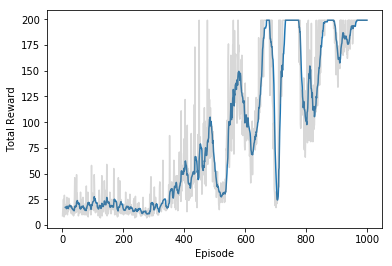

In [22]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [24]:
env.close()